# Computing window matrices with autodiff - anisotropic case

Let's try to implement some anisotropy.

In [1]:
from pathlib import Path
from functools import partial
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.' # NOTE: jax preallocates GPU (default 75%)

import numpy as np
import jax
from jax import numpy as jnp
from jax import random

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 4)

from jaxpower import (ParticleField, FKPField,
compute_mesh_power, compute_fkp_power, compute_normalization)
from jaxwindow.mock import generate_anisotropic_gaussian_mesh

## Global line-of-sight, in box

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20241221-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


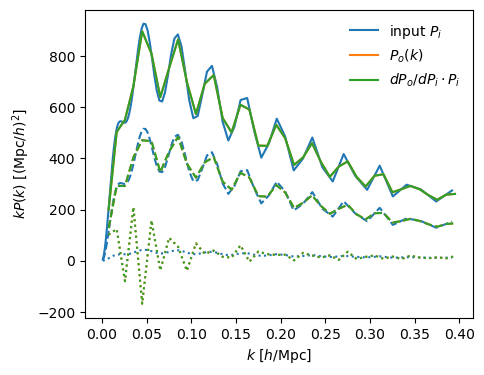

In [2]:
# To highlight the effect of the window convolution,
# we generate a power spectrum with high frequency BAO

from cosmoprimo.fiducial import DESI
cosmo = DESI(engine='eisenstein_hu_nowiggle')
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)
kin = jnp.geomspace(1e-3, 1e1, 200)
pkin = pk(kin) * (1. + 0.2 * np.sin(kin / 0.006))
ells = (0, 2, 4)

f, b = 0.8, 1.5
pkb = b**2 * pkin
beta = f / b
poles = [(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pkb,
         0.9 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pkb,
          8. / 35 * beta ** 2 * pkb]
poles = jnp.array(poles)


def mock_box(poles, unitary_amplitude=True, los='x', boxsize=1000., meshsize=128, seed=42):
    boxcenter = np.array((1e9, 0., 0.))
    mesh = generate_anisotropic_gaussian_mesh(kin, poles, unitary_amplitude=unitary_amplitude,
                                              boxsize=boxsize, meshsize=meshsize, boxcenter=boxcenter,
                                              los=los, seed=seed)
    edges = {'step': 0.01}
    return compute_mesh_power(mesh, edges=edges, ells=ells, los={'local': 'firstpoint'}.get(los, los))

get_pk = lambda pkin, **kwargs: mock_box(pkin, **kwargs)
get_wmat = lambda pkin, **kwargs: jax.jacrev(lambda pkin: get_pk(pkin, **kwargs).power.real)(pkin)
get_pk = jax.jit(get_pk)
get_wmat = jax.jit(get_wmat)

seed = random.key(42)
# Get one power spectrum
pk = get_pk(poles, seed=seed)
pkt = jnp.tensordot(get_wmat(poles, seed=seed), poles, axes=((2, 3), (0, 1)))
k, edges = pk.k, pk.edges

ax = plt.gca()
maskin = kin < edges[-1]
linestyles = ['-', '--', ':']
colors = ['C0', 'C1', 'C2']
labels = ['input $P_i$', '$P_o(k)$', '$dP_o/dP_i \cdot P_i$']
for color, label in zip(colors, labels):
    ax.plot([], [], color=color, linestyle='-', label=label)
for ill, ell in enumerate(ells):
    linestyle = linestyles[ill]
    ax.plot(kin[maskin], kin[maskin] * poles[ill][maskin], linestyle=linestyle, color=colors[0])
    ax.plot(k, k * pk.power[ill].real, linestyle=linestyle, color=colors[1])
    ax.plot(k, k * pkt[ill], linestyle=linestyle, color=colors[2])
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

Green on top of orange - all good!

Previously we generated a Gaussian field trivially with the anisotropic power spectrum $P(k, \mu) = \sum_{\ell = 0}^{4} P_\ell(k) \mathcal{L}_\ell(\mu)$, as $\mu$ was just $k_x / k$.

This will not work for a varying line-of-sight. In this case we generate two Gaussian fields $a_\ell(k)$, and $\delta(\mathbf{k}) = \sum_{\ell = 0}^{2} a_\ell(k) \mathcal{L}_\ell(\mu)$. Let's check that this works.

In [3]:
get_pk = lambda pkin, **kwargs: mock_box(pkin, **kwargs)
get_wmat = lambda pkin, **kwargs: jax.jacrev(lambda pkin: get_pk(pkin, **kwargs).power.real)(pkin)
get_pk = jax.jit(get_pk, static_argnames=['los'])
get_wmat = jax.jit(get_wmat, static_argnames=['los'])

seed = random.key(42)
# Get one power spectrum
pkx = get_pk(poles, seed=seed)

from tqdm import trange
pks, pkts = [], []
npk, npkt = 100, 100
with trange(npk) as t:
    for imock in t:
        seed = random.key(2 * imock)
        pks.append(get_pk(poles, los='local', seed=seed))
with trange(npkt) as t:
    for imock in t:
        # Here we do not use the same seeds
        seed = random.key(2 * imock + 1)
        wmat = get_wmat(poles, los='local', seed=seed)
        pkts.append(jnp.tensordot(wmat, poles, axes=((2, 3), (0, 1))))

100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


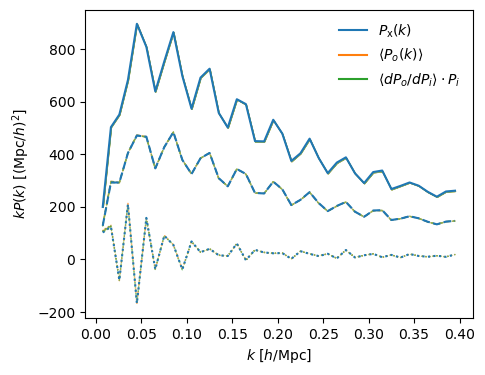

In [4]:
k, edges = pks[0].k, pks[0].edges
pk_mean, pk_std = np.mean([pk.power.real for pk in pks], axis=0), np.std([pk.power.real for pk in pks], axis=0) / npk**0.5
pkt_mean, pkt_std = np.mean(pkts, axis=0), np.std(pkts, axis=0) / npkt**0.5

ax = plt.gca()
maskin = kin < edges[-1]
linestyles = ['-', '--', ':']
colors = ['C0', 'C1', 'C2']
labels = [r'$P_\mathrm{x}(k)$', r'$\langle P_o(k) \rangle$', r'$\langle dP_o/dP_i \rangle \cdot P_i$']
for color, label in zip(colors, labels):
    ax.plot([], [], color=color, linestyle='-', label=label)
for ill, ell in enumerate(ells):
    linestyle = linestyles[ill]
    ax.plot(k, k * pkx.power[ill].real, linestyle=linestyle, color=colors[0])
    kw = dict(lw=1., alpha=0.5)
    ax.fill_between(k, k * (pk_mean - pk_std)[ill], k * (pk_mean + pk_std)[ill], linestyle=linestyle, color=colors[1], **kw)
    ax.fill_between(k, k * (pkt_mean - pkt_std)[ill], k * (pkt_mean + pkt_std)[ill], linestyle=linestyle, color=colors[2], **kw)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

Box is at infinity, so there is no difference between local and global line-of-sight - all good!

## Global line-of-sight, survey geometry

In [5]:
def gaussian_survey(boxsize=2000., meshsize=128, size=int(1e6), seed=random.key(42), scale=0.1, paint=False):
    # Generate Gaussian-distributed positions
    boxcenter = jnp.array((boxsize * 0.75, 0., 0.))
    positions = scale * boxsize * random.normal(seed, shape=(size, 3)) + boxcenter
    toret = ParticleField(positions, boxcenter=boxcenter, boxsize=boxsize, meshsize=meshsize)
    if paint: toret = toret.paint(resampler='cic', interlacing=0, compensate=False)
    return toret

def mock_survey(poles, selection, unitary_amplitude=True, los='x', seed=random.key(42)):
    # Generate Gaussian field
    mesh = generate_anisotropic_gaussian_mesh(kin, poles, unitary_amplitude=unitary_amplitude,
                                              boxsize=selection.boxsize, meshsize=selection.meshsize, boxcenter=selection.boxcenter,
                                              los=los, seed=seed)
    edges = {'step': 0.01}
    # Multiply Gaussian field with survey selection function, then compute power spectrum
    norm = compute_normalization(selection, selection)
    return compute_mesh_power(mesh * selection, edges=edges, ells=ells, los={'local': 'firstpoint'}.get(los, los)).clone(norm=norm)

In [6]:
selection = gaussian_survey(paint=True)

get_pk = lambda pkin, **kwargs: mock_survey(pkin, selection, **kwargs)
get_wmat = lambda pkin, **kwargs: jax.jacrev(lambda pkin: get_pk(pkin, **kwargs).power.real)(pkin)
get_pk = jax.jit(get_pk)
get_wmat = jax.jit(get_wmat)

from tqdm import trange
pks, wmats, pkts = [], [], []
npk, npkt = 100, 100
with trange(npk) as t:
    for imock in t:
        seed = random.key(2 * imock)
        pks.append(get_pk(poles, seed=seed))
with trange(npkt) as t:
    for imock in t:
        # Here we do not use the same seeds
        seed = random.key(2 * imock + 1)
        wmat = get_wmat(poles, seed=seed)
        wmats.append(wmat)
        pkts.append(jnp.tensordot(wmat, poles, axes=((2, 3), (0, 1))))

100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


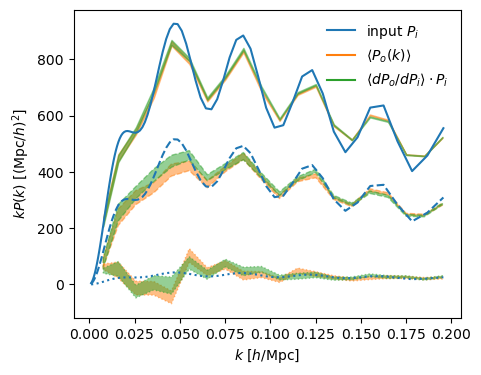

In [7]:
k, edges = pks[0].k, pks[0].edges
pk_mean, pk_std = np.mean([pk.power.real for pk in pks], axis=0), np.std([pk.power.real for pk in pks], axis=0) / npk**0.5
pkt_mean, pkt_std = np.mean(pkts, axis=0), np.std(pkts, axis=0) / npkt**0.5

ax = plt.gca()
maskin = kin < edges[-1]
linestyles = ['-', '--', ':']
colors = ['C0', 'C1', 'C2']
labels = ['input $P_i$', r'$\langle P_o(k) \rangle$', r'$\langle dP_o/dP_i \rangle \cdot P_i$']
for color, label in zip(colors, labels):
    ax.plot([], [], color=color, linestyle='-', label=label)
for ill, ell in enumerate(ells):
    linestyle = linestyles[ill]
    ax.plot(kin[maskin], kin[maskin] * poles[ill][maskin], linestyle=linestyle, color=colors[0])
    kw = dict(lw=1., alpha=0.5)
    ax.fill_between(k, k * (pk_mean - pk_std)[ill], k * (pk_mean + pk_std)[ill], linestyle=linestyle, color=colors[1], **kw)
    ax.fill_between(k, k * (pkt_mean - pkt_std)[ill], k * (pkt_mean + pkt_std)[ill], linestyle=linestyle, color=colors[2], **kw)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

All good again!

## Local line-of-sight, survey geometry

In [8]:
selection = gaussian_survey(paint=True)

get_pk = lambda pkin, **kwargs: mock_survey(pkin, selection, **kwargs)
get_wmat = lambda pkin, **kwargs: jax.jacrev(lambda pkin: get_pk(pkin, **kwargs).power.real)(pkin)
get_pk = jax.jit(get_pk, static_argnames=['los'])
get_wmat = jax.jit(get_wmat, static_argnames=['los'])

from tqdm import trange
pks, wmats, pkts = [], [], []
npk, npkt = 100, 100
with trange(npk) as t:
    for imock in t:
        seed = random.key(2 * imock)
        pks.append(get_pk(poles, los='local', seed=seed))
with trange(npkt) as t:
    for imock in t:
        # Here we do not use the same seeds
        seed = random.key(2 * imock + 1)
        wmat = get_wmat(poles, los='local', seed=seed)
        wmats.append(wmat)
        pkts.append(jnp.tensordot(wmat, poles, axes=((2, 3), (0, 1))))

100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


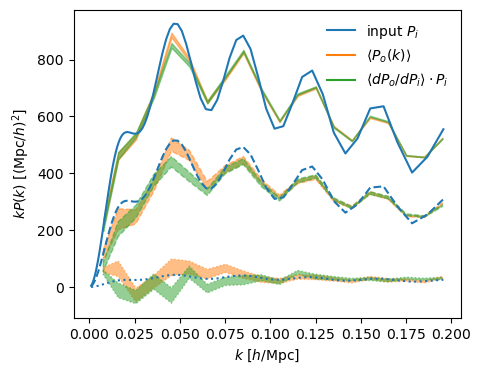

In [9]:
k, edges = pks[0].k, pks[0].edges
pk_mean, pk_std = np.mean([pk.power.real for pk in pks], axis=0), np.std([pk.power.real for pk in pks], axis=0) / npk**0.5
pkt_mean, pkt_std = np.mean(pkts, axis=0), np.std(pkts, axis=0) / npkt**0.5

ax = plt.gca()
maskin = kin < edges[-1]
linestyles = ['-', '--', ':']
colors = ['C0', 'C1', 'C2']
labels = ['input $P_i$', r'$\langle P_o(k) \rangle$', r'$\langle dP_o/dP_i \rangle \cdot P_i$']
for color, label in zip(colors, labels):
    ax.plot([], [], color=color, linestyle='-', label=label)
for ill, ell in enumerate(ells):
    linestyle = linestyles[ill]
    ax.plot(kin[maskin], kin[maskin] * poles[ill][maskin], linestyle=linestyle, color=colors[0])
    kw = dict(lw=1., alpha=0.5)
    ax.fill_between(k, k * (pk_mean - pk_std)[ill], k * (pk_mean + pk_std)[ill], linestyle=linestyle, color=colors[1], **kw)
    ax.fill_between(k, k * (pkt_mean - pkt_std)[ill], k * (pkt_mean + pkt_std)[ill], linestyle=linestyle, color=colors[2], **kw)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()